In [1]:
from utils import *

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda:0


*TODO*

range of pixel intensity - consistent range

customize mean and std

cropping

denoising

histogram equalization

1500 images + 1300 val

hugging face models

Preprocessing, class imbalance and weights, transfear learning fromm xray, ultrasound, ensemble learning, voting

Densenet

In [2]:
drive_dir = "/content/drive/MyDrive/OCT PVD/ZhangLabData/"
drive_dir = "/content/"
drive_dir = ""

train_dir = drive_dir + "CellData/OCT/train"
test_dir = drive_dir + "CellData/OCT/test"

In [3]:
# Use the CLAHETransform in your transforms pipeline
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    
    ## Choose pre-processing ##
    # CLAHETransform(),  # Apply CLAHE
    # CannyEdgeTransform(),  # Apply Canny edge detection

    ## Augmentation ##
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    ## Choose pre-processing ##
    # CLAHETransform(),  # Apply CLAHE
    # CannyEdgeTransform(),  # Apply Canny edge detection
    
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [4]:
# Load training and testing datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [5]:
classes = train_dataset.classes
classes

['CNV', 'DME', 'DRUSEN', 'NORMAL']

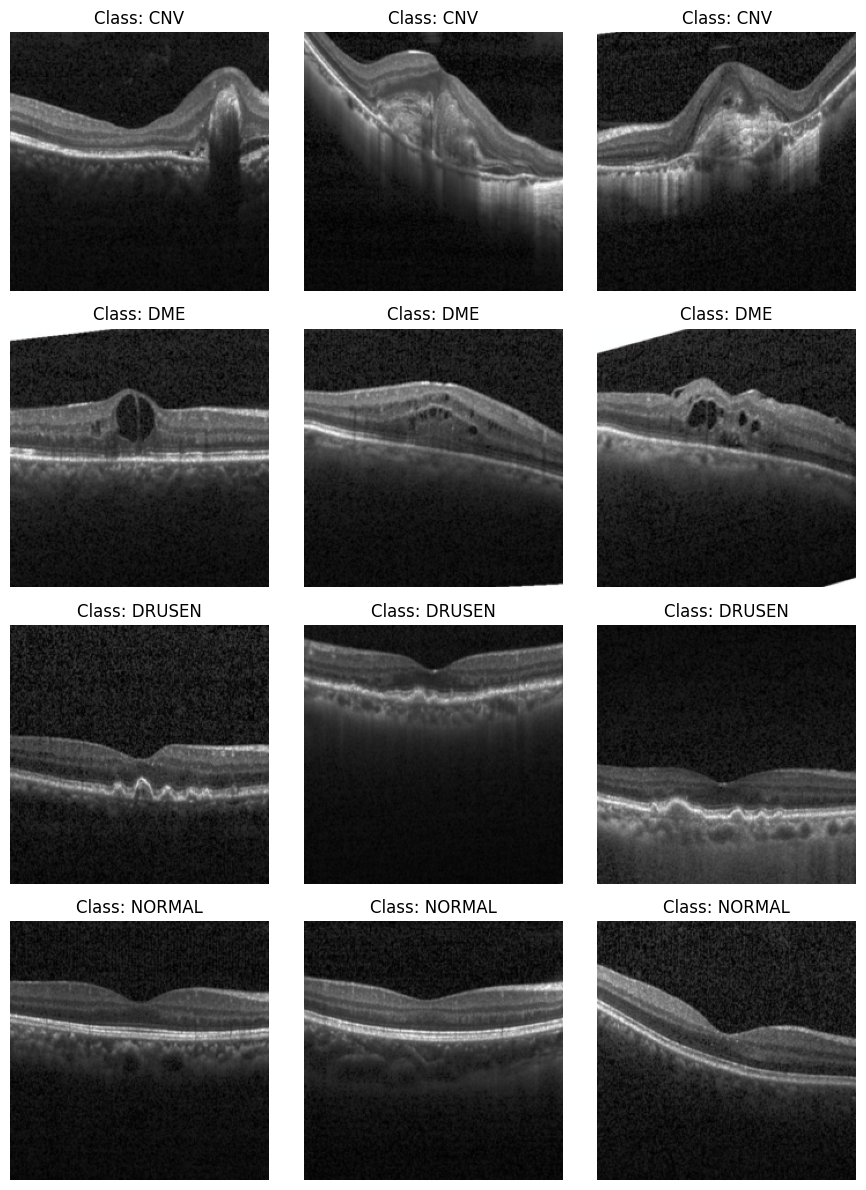

In [6]:
visualize_samples(test_dataset, classes) ### RAW

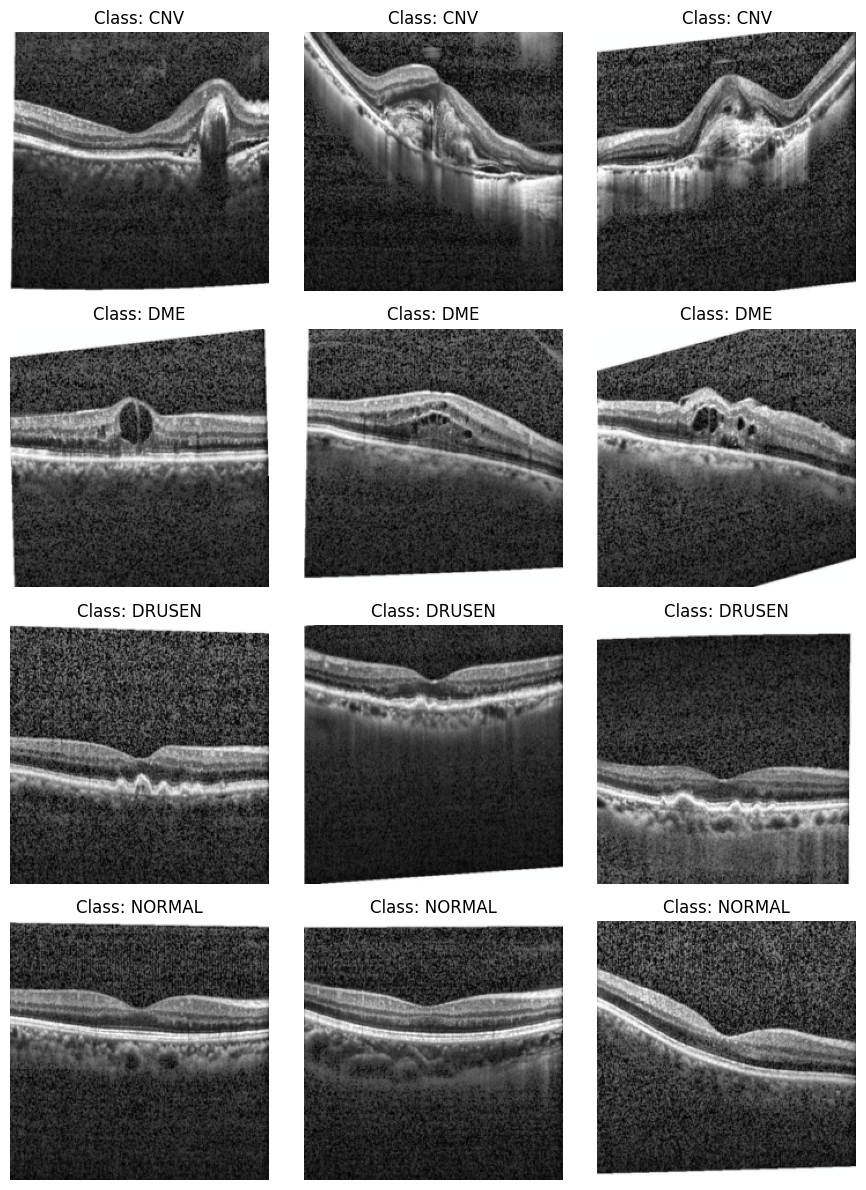

In [37]:
visualize_samples(test_dataset, classes) ### CLAHE

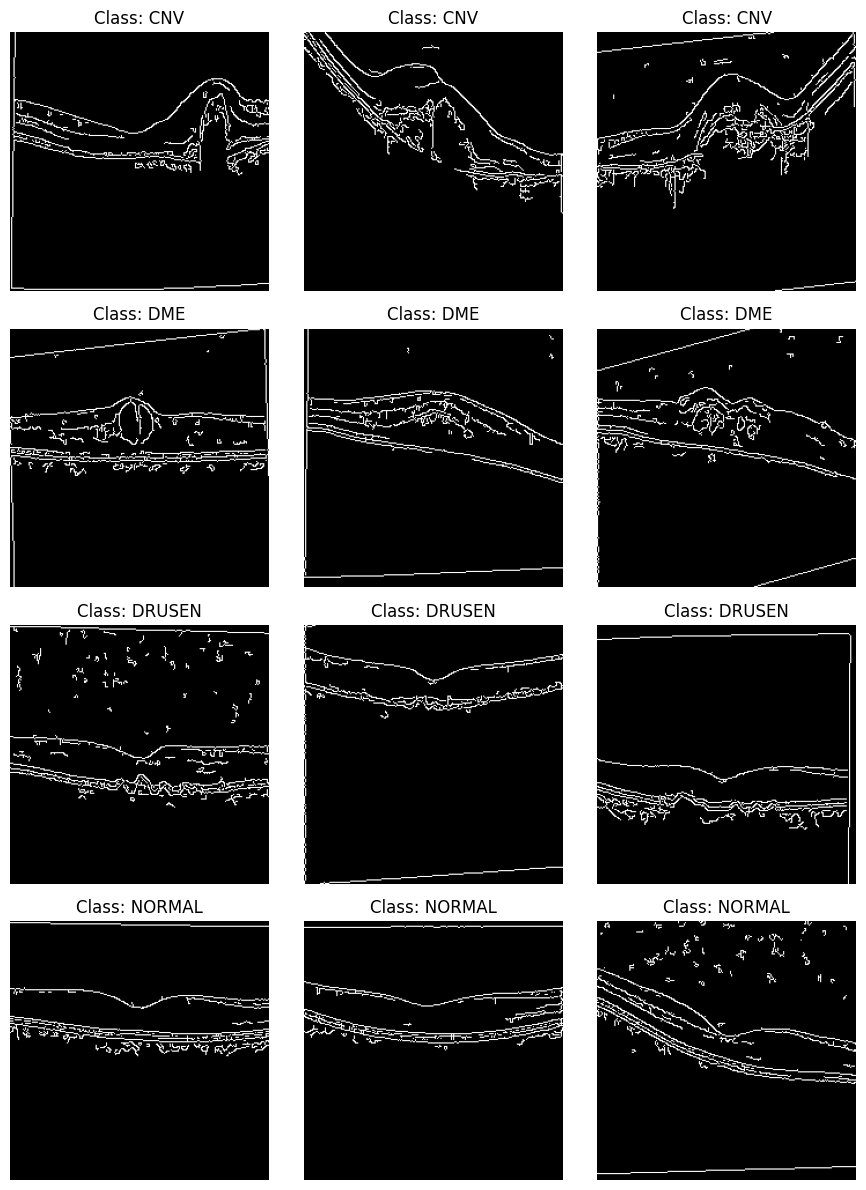

In [47]:
visualize_samples(test_dataset, classes) ### Edge

In [7]:
# Count the number of occurrences of each label
class_counts = Counter(train_dataset.targets)
for class_idx, count in class_counts.items():
    print(f"Class '{classes[class_idx]}' has {count} samples.")

Class 'CNV' has 37205 samples.
Class 'DME' has 11348 samples.
Class 'DRUSEN' has 8616 samples.
Class 'NORMAL' has 51140 samples.


In [11]:
## Balancing Dataset

min_samples_per_class = min(class_counts.values()) # Use this to limit count to class with min number of images 
min_samples_per_class = 2000 

class_indices = defaultdict(list)

# Populate the class indices dictionary
for idx, label in enumerate(train_dataset.targets):
    class_indices[label].append(idx)

balanced_indices = []
for label, indices in class_indices.items():
    # Randomly sample 'min_samples_per_class' indices from each class
    sampled_indices = random.sample(indices, min_samples_per_class)
    balanced_indices.extend(sampled_indices)

# Create a balanced subset of the original dataset
balanced_train_dataset = Subset(train_dataset, balanced_indices)
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True, drop_last=True)

print(f"Total samples in the balanced dataset: {len(balanced_train_dataset)}")

subset_labels = [train_dataset.targets[idx] for idx in balanced_train_dataset.indices]
subset_class_counts = Counter(subset_labels)
for class_idx, count in subset_class_counts.items():
    print(f"Class '{classes[class_idx]}' has {count} samples in the balanced subset.")

Total samples in the balanced dataset: 8000
Class 'CNV' has 2000 samples in the balanced subset.
Class 'DME' has 2000 samples in the balanced subset.
Class 'DRUSEN' has 2000 samples in the balanced subset.
Class 'NORMAL' has 2000 samples in the balanced subset.


### Resnet50 RAW

In [25]:
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 4) 
)

resnet50 = resnet50.to(device)
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)
num_epochs = 5
model_name="resnet50"

c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Epoch [1/5], Train Loss: 50.3100, Train Acc: 0.6870, Val Loss: 35.5991, Val Accuracy: 0.78, Epoch Time: 84.98s
Saving weights...


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch [2/5], Train Loss: 49.5802, Train Acc: 0.6869, Val Loss: 32.1091, Val Accuracy: 0.80, Epoch Time: 82.73s
Saving weights...


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


Epoch [3/5], Train Loss: 48.7666, Train Acc: 0.7010, Val Loss: 27.9805, Val Accuracy: 0.86, Epoch Time: 83.44s
Saving weights...


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch [4/5], Train Loss: 49.1061, Train Acc: 0.7017, Val Loss: 31.3519, Val Accuracy: 0.86, Epoch Time: 83.85s


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Epoch [5/5], Train Loss: 48.3066, Train Acc: 0.7065, Val Loss: 32.3099, Val Accuracy: 0.82, Epoch Time: 83.58s


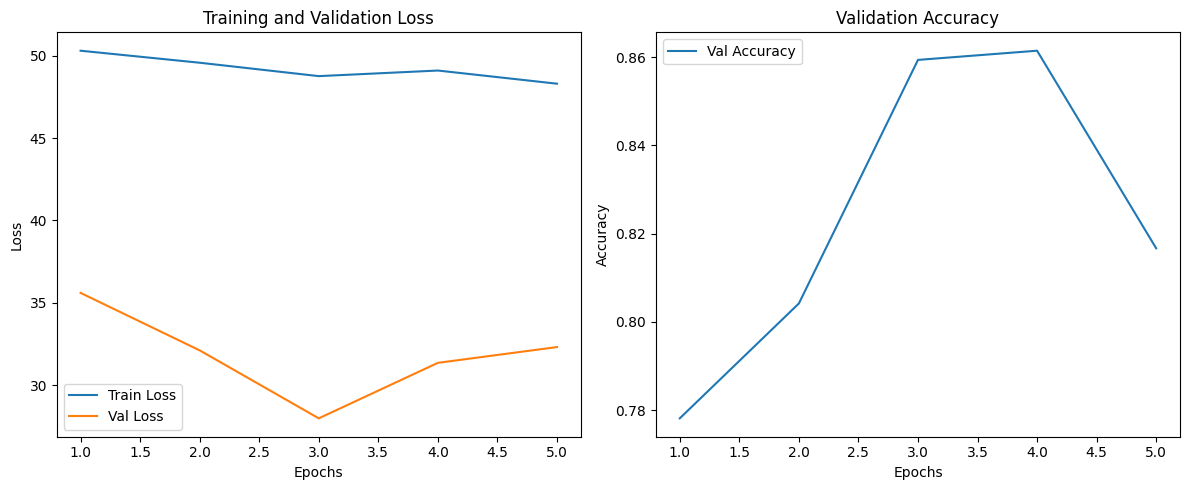

Total Training Time: 419.26s


In [28]:
resnet50, _, _ = train_fn(resnet50, balanced_train_loader, test_loader, model_name, num_epochs, device=device, optimizer=optimizer)

In [22]:
resnet50.load_state_dict(torch.load("models/" + model_name + ".pth"))
_ = eval_fn(resnet50, test_loader, device=device, binary = False)

Validation Accuracy: 0.8323
Validation F1: 0.8314


### Densenet RAW

### Extra

In [ ]:
# class_weights = torch.tensor([1.0, 1.2, 1.5, 1.3]).to(device)  # Adjust based on class frequencies
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# from sklearn.utils.class_weight import compute_class_weight

# # Assuming `train_dataset` is an ImageFolder dataset
# class_counts = [len(np.where(np.array(train_dataset.targets) == i)[0]) for i in range(len(train_dataset.classes))]

# # Compute class weights: (Inverse of frequency)
# class_weights = compute_class_weight('balanced', classes=np.arange(len(class_counts)), y=np.array(train_dataset.targets))
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# # Use the weights in CrossEntropyLoss
# criterion = nn.CrossEntropyLoss(weight=class_weights)



In [4]:
import numpy as np

from tqdm import tqdm
for epoch in (range(num_epochs)):
    # Training phase
    resnet50.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    epoch_acc = correct_train / total_train
    torch.save(resnet50.state_dict(), "resnet50_finetuned.pth")

    # Validation phase
    resnet50.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for _, (inputs, labels) in tqdm(enumerate(test_loader)):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(test_dataset)
    val_losses.append(val_epoch_loss)
    val_epoch_acc = correct_val / total_val

    print(f"Epoch [{epoch + 1}/{num_epochs}]"
          f" Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}"
          f" Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")



  5%|▌         | 1/20 [1:24:08<26:38:44, 5048.67s/it]

Epoch [1/20] Train Loss: 0.5529, Train Acc: 0.8092 Val Loss: 0.4728, Val Acc: 0.7656


 10%|█         | 2/20 [2:58:21<27:01:08, 5403.78s/it]

Epoch [2/20] Train Loss: 0.4897, Train Acc: 0.8311 Val Loss: 0.4533, Val Acc: 0.8063


 15%|█▌        | 3/20 [4:26:19<25:14:49, 5346.43s/it]

Epoch [3/20] Train Loss: 0.4654, Train Acc: 0.8404 Val Loss: 0.5288, Val Acc: 0.7625


 20%|██        | 4/20 [6:08:02<25:05:23, 5645.20s/it]

Epoch [4/20] Train Loss: 0.4520, Train Acc: 0.8444 Val Loss: 0.4653, Val Acc: 0.8000


 25%|██▌       | 5/20 [7:49:41<24:12:15, 5809.02s/it]

Epoch [5/20] Train Loss: 0.4458, Train Acc: 0.8462 Val Loss: 0.5815, Val Acc: 0.7365


 30%|███       | 6/20 [9:31:32<22:59:22, 5911.58s/it]

Epoch [6/20] Train Loss: 0.4320, Train Acc: 0.8510 Val Loss: 0.5072, Val Acc: 0.7604


 35%|███▌      | 7/20 [11:13:35<21:35:49, 5980.74s/it]

Epoch [7/20] Train Loss: 0.4284, Train Acc: 0.8524 Val Loss: 0.5392, Val Acc: 0.7656


 35%|███▌      | 7/20 [12:40:19<23:32:02, 6517.10s/it]


KeyboardInterrupt: 